In [23]:
# Import libraries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, roc_curve)

import warnings
warnings.filterwarnings('ignore')

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

print(" Libraries imported successfully")

 Libraries imported successfully


## 1. Load Preprocessed Data

In [24]:
# Load the preprocessed data
with open('../models/preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
feature_names = data['feature_names']
preprocessor = data['preprocessor']

print(" Data loaded successfully:")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Number of features: {len(feature_names)}")
print(f"  Feature names: {feature_names[:10]}...")

 Data loaded successfully:
  X_train shape: (5634, 30)
  X_test shape: (1409, 30)
  y_train shape: (5634,)
  y_test shape: (1409,)
  Number of features: 30
  Feature names: ['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes']...


## 2. Baseline Decision Tree with Regularization

In [43]:
## 2. Baseline Decision Tree with Regularization

print(" Training Baseline Decision Tree with Regularization...")

# Baseline with constraints to prevent overfitting
dt_baseline = DecisionTreeClassifier(
    max_depth=8,  # Control tree complexity
    min_samples_split=20,  # Require more samples to split
    min_samples_leaf=10,  # Require minimum samples in leaves
    max_features='sqrt',  # Consider sqrt(features) at each split
    random_state=42
)

dt_baseline.fit(X_train, y_train)

# Make predictions
y_train_pred = dt_baseline.predict(X_train)
y_test_pred = dt_baseline.predict(X_test)

# Calculate metrics
print("\n Baseline Model Performance (with regularization):")
print("=" * 50)
print("Training Set:")
print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred, zero_division=0):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred, zero_division=0):.4f}")
print(f"  F1-Score:  {f1_score(y_train, y_train_pred, zero_division=0):.4f}")

print("\nTest Set:")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_test_pred, zero_division=0):.4f}")

# Check for overfitting
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"\n Overfitting check:")
print(f"  Training Accuracy: {train_acc:.4f}")
print(f"  Test Accuracy:     {test_acc:.4f}")
print(f"  Difference:        {train_acc - test_acc:.4f}")

if train_acc - test_acc > 0.1:
    print("  Warning: Possible overfitting detected!")
elif train_acc - test_acc > 0.05:
    print("  Moderate overfitting detected")
else:
    print(" Overfitting seems minimal")

 Training Baseline Decision Tree with Regularization...

 Baseline Model Performance (with regularization):
Training Set:
  Accuracy:  0.8033
  Precision: 0.6447
  Recall:    0.5766
  F1-Score:  0.6088

Test Set:
  Accuracy:  0.7850
  Precision: 0.6041
  Recall:    0.5508
  F1-Score:  0.5762

 Overfitting check:
  Training Accuracy: 0.8033
  Test Accuracy:     0.7850
  Difference:        0.0184
 Overfitting seems minimal


## 3. Hyperparameter Tuning

In [27]:
print(" Starting Hyperparameter Tuning...")

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

# Create GridSearchCV
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearch
print(" Tuning hyperparameters (this may take a minute)...")
grid_search.fit(X_train, y_train)

print("\n Hyperparameter tuning complete!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

 Starting Hyperparameter Tuning...
 Tuning hyperparameters (this may take a minute)...
Fitting 5 folds for each of 448 candidates, totalling 2240 fits

 Hyperparameter tuning complete!
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation F1 score: 0.6190


## 4. Train Tuned Model

In [33]:
# Get the best model
dt_best = grid_search.best_estimator_

# Train with best parameters
dt_best.fit(X_train, y_train)

# Make predictions with best model
y_train_pred_best = dt_best.predict(X_train)
y_test_pred_best = dt_best.predict(X_test)
y_test_proba_best = dt_best.predict_proba(X_test)[:, 1]  # Probabilities for ROC

print("Best Model Performance:")
print("=" * 40)
print("Training Set:")
print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred_best):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred_best):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred_best):.4f}")
print(f"  F1-Score:  {f1_score(y_train, y_train_pred_best):.4f}")

print("\nTest Set:")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred_best):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred_best):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred_best):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_test_pred_best):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_test_proba_best):.4f}")

Best Model Performance:
Training Set:
  Accuracy:  0.7577
  Precision: 0.5267
  Recall:    0.8569
  F1-Score:  0.6524

Test Set:
  Accuracy:  0.7410
  Precision: 0.5077
  Recall:    0.7941
  F1-Score:  0.6194
  ROC-AUC:   0.8316


## 5. Feature Importance Analysis

 Feature Importance Analysis


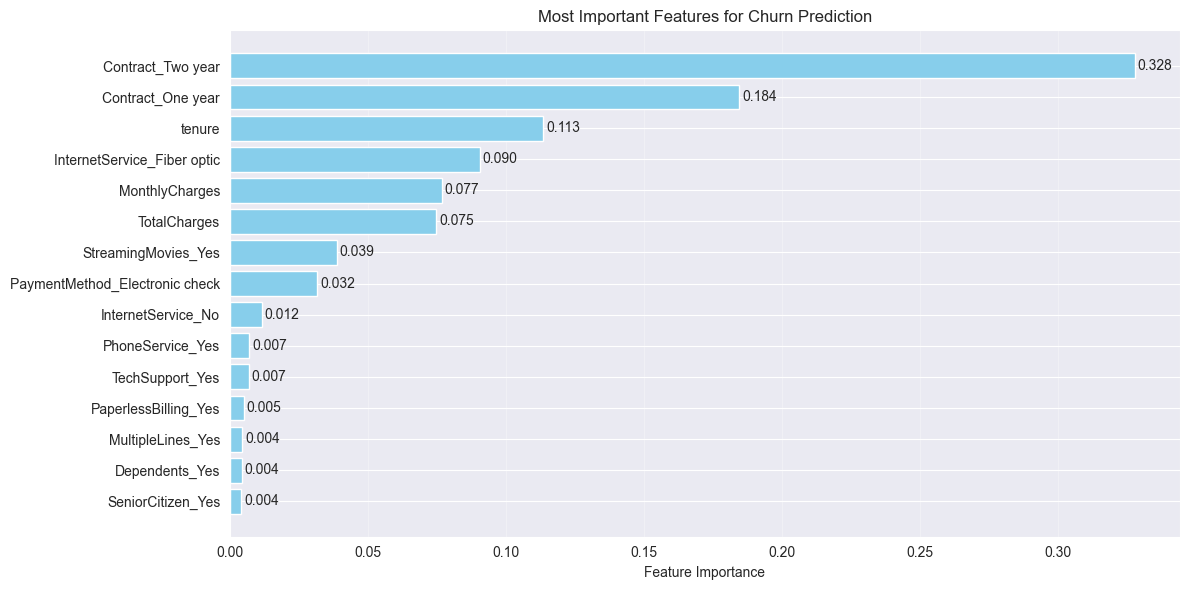


 Top  Important Features:
                       feature  importance
             Contract_Two year    0.327656
             Contract_One year    0.184428
                        tenure    0.113472
   InternetService_Fiber optic    0.090475
                MonthlyCharges    0.076768
                  TotalCharges    0.074819
           StreamingMovies_Yes    0.038703
PaymentMethod_Electronic check    0.031656
            InternetService_No    0.011548
              PhoneService_Yes    0.007074


In [46]:
print(" Feature Importance Analysis")

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_best.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot features
plt.figure(figsize=(12, 6))
top_n = min(15, len(feature_importance))
bars = plt.barh(range(top_n),
                feature_importance['importance'].head(top_n)[::-1],
                color='skyblue')
plt.yticks(range(top_n), feature_importance['feature'].head(top_n)[::-1])
plt.xlabel('Feature Importance')
plt.title(f'Most Important Features for Churn Prediction')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

print("\n Top  Important Features:")
print(feature_importance.head(10).to_string(index=False))

## 6. Model Evaluation

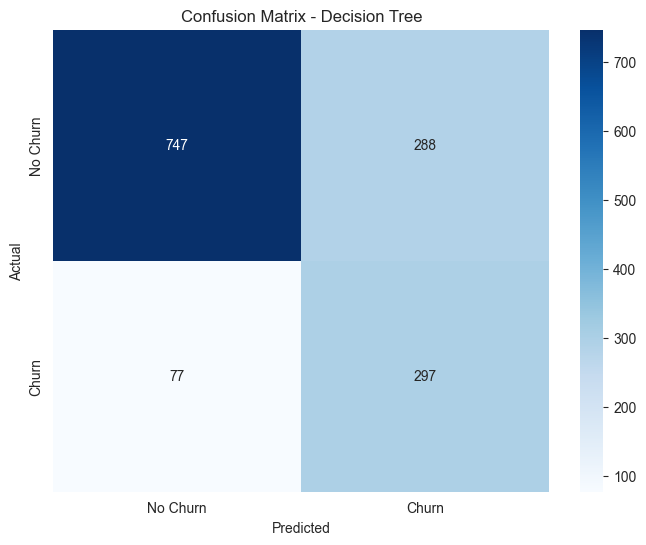


 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.91      0.72      0.80      1035
       Churn       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [35]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Report
print("\n Classification Report:")
print(classification_report(y_test, y_test_pred_best,
                           target_names=['No Churn', 'Churn']))

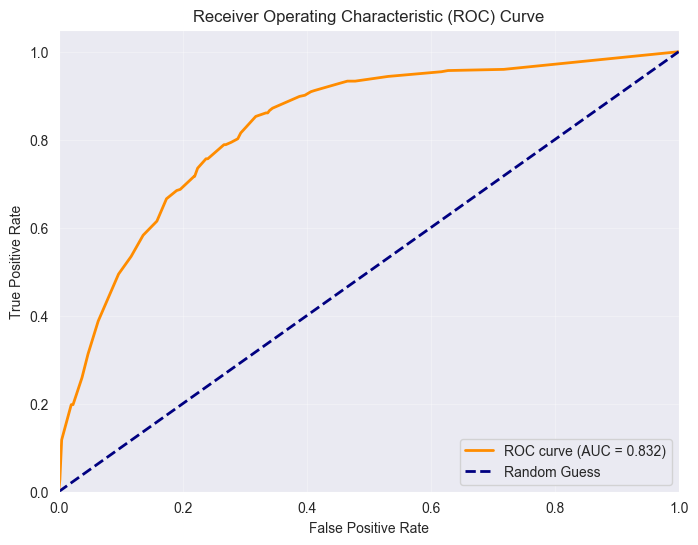

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba_best)
roc_auc = roc_auc_score(y_test, y_test_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Save Model

In [44]:
print(" Saving model and results...")

results = {
    'model': dt_best,
    'best_params': grid_search.best_params_,
    'feature_importance': feature_importance,
    'test_predictions': y_test_pred_best,
    'test_probabilities': y_test_proba_best,
    'metrics': {
        'accuracy': accuracy_score(y_test, y_test_pred_best),
        'precision': precision_score(y_test, y_test_pred_best),
        'recall': recall_score(y_test, y_test_pred_best),
        'f1': f1_score(y_test, y_test_pred_best),
        'roc_auc': roc_auc_score(y_test, y_test_proba_best)
    }
}

# Save to file using pickle
save_path = '../models/decision_tree_model.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f" Decision Tree model saved to: {save_path}")

 Saving model and results...
 Decision Tree model saved to: ../models/decision_tree_model.pkl
